<a href="https://colab.research.google.com/github/tommyliphysics/tommyli-ml/blob/main/ai-detector/notebooks/eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

samples = pd.read_csv('https://raw.githubusercontent.com/tommyliphysics/tommyli-ml/main/ai_detector/notebooks/samples.csv')
test = samples[samples['TTV split']==-1]
test

,text,source,topic,TTV split,label
2,It would be unwise to judge that that either n...,imdb,movie review,-1.0,0
4,"I am a fan of Jess Franco's bizarre style, and...",imdb,movie review,-1.0,0
20,"""Lights of New York"" originally started out as...",imdb,movie review,-1.0,0
22,"OK, so my summary line is a cheap trick. But t...",imdb,movie review,-1.0,0
38,"I can't quite say that ""Jerry Springer:Ringmas...",imdb,movie review,-1.0,0
...,...,...,...,...,...
20812,"A standards organization, also known as a stan...",wikipedia by GPT,Standards organization,-1.0,1
20813,The International Electrotechnical Commission ...,wikipedia by GPT,International Electrotechnical Commission,-1.0,1
20814,"Bhutan, officially known as the Kingdom of Bhu...",wikipedia by GPT,Bhutan,-1.0,1
20815,Jigme Khesar Namgyel Wangchuck is a prominent ...,wikipedia by GPT,Jigme Khesar Namgyel Wangchuck,-1.0,1


In [2]:
from transformers import pipeline

model_deberta = pipeline('text-classification', model='tommyliphys/ai-detector-deberta', max_length=512, truncation=True)
model_distilbert = pipeline('text-classification', model='tommyliphys/ai-detector-distilbert', max_length=512, truncation=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/263M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at tommyliphys/ai-detector-distilbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Some layers from the model checkpoint at tommyliphys/ai-detector-distilbert were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at tommyliphys/ai-detector-distilbert and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
predictions = {}
predictions['deberta'] = model_deberta(test['text'].tolist(), return_all_scores=True)
predictions['distilbert'] = model_distilbert(test['text'].tolist(), return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [27]:
y_test = test['label']
y_probas = {}
y_preds = {}
for model_name in predictions:
    y_probas[model_name] = [predictions[model_name][n][1]['score'] for n in range(len(predictions[model_name]))]
    y_preds[model_name] = [y_proba >= 0.5 for y_proba in y_probas[model_name]]

## Classification reports

In [16]:
from sklearn.metrics import *

def classification_report(y_eval, y_pred):
    cm = confusion_matrix(y_eval, y_pred)
    metrics = pd.DataFrame([
        {'value': accuracy_score(y_eval, y_pred)},
        {'value': precision_score(y_eval, y_pred)},
        {'value': recall_score(y_eval,y_pred)},
        {'value': f1_score(y_eval,y_pred)}], index=['accuracy', 'precision', 'recall', 'f1'])
    return pd.DataFrame(cm,columns=['human','AI'],index = ['human','AI']), metrics

In [28]:
cm_dict = {}
metrics_dict = {}

for model_name in predictions:
    cm, metrics = classification_report(y_test, y_preds[model_name])
    cm_dict[model_name] = cm
    metrics_dict[model_name] = metrics

In [29]:
cm_dict['deberta']

,human,AI
human,2391,23
AI,0,2358


In [30]:
cm_dict['distilbert']

,human,AI
human,2391,23
AI,0,2358


In [31]:
metrics_dict['deberta']

,value
accuracy,0.995180
precision,0.990340
recall,1.000000
f1,0.995147


In [32]:
metrics_dict['distilbert']

,value
accuracy,0.995180
precision,0.990340
recall,1.000000
f1,0.995147


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_roc_pr(y_test, y_probas, labels=None, title=None, save=None, save_format=None):
    fig, axes = plt.subplots(1,2, figsize=(15, 8))

    for i in range(len(y_probas)):
        fpr, tpr, _ = roc_curve(y_test, y_probas[i])
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(y_test, y_probas[i])
        pr_auc = auc(recall, precision)

        sns.lineplot(x=fpr, y=tpr, ax = axes[0], label=f'{labels[i]}: auc = {roc_auc:.2f}')
        sns.lineplot(x=recall, y=precision, ax = axes[1], label=f'{labels[i]}: auc = {pr_auc:.2f}')

    axes[0].set_xlabel("true positive rate")
    axes[0].set_ylabel("false positive rate")

    axes[1].set_xlabel("recall")
    axes[1].set_ylabel("precision")

    if title != None:
        fig.suptitle('ROC and precision-recall for '+title)
    plt.tight_layout()
    if save != None:
        plt.savefig(save, format=save_format)
    plt.show()

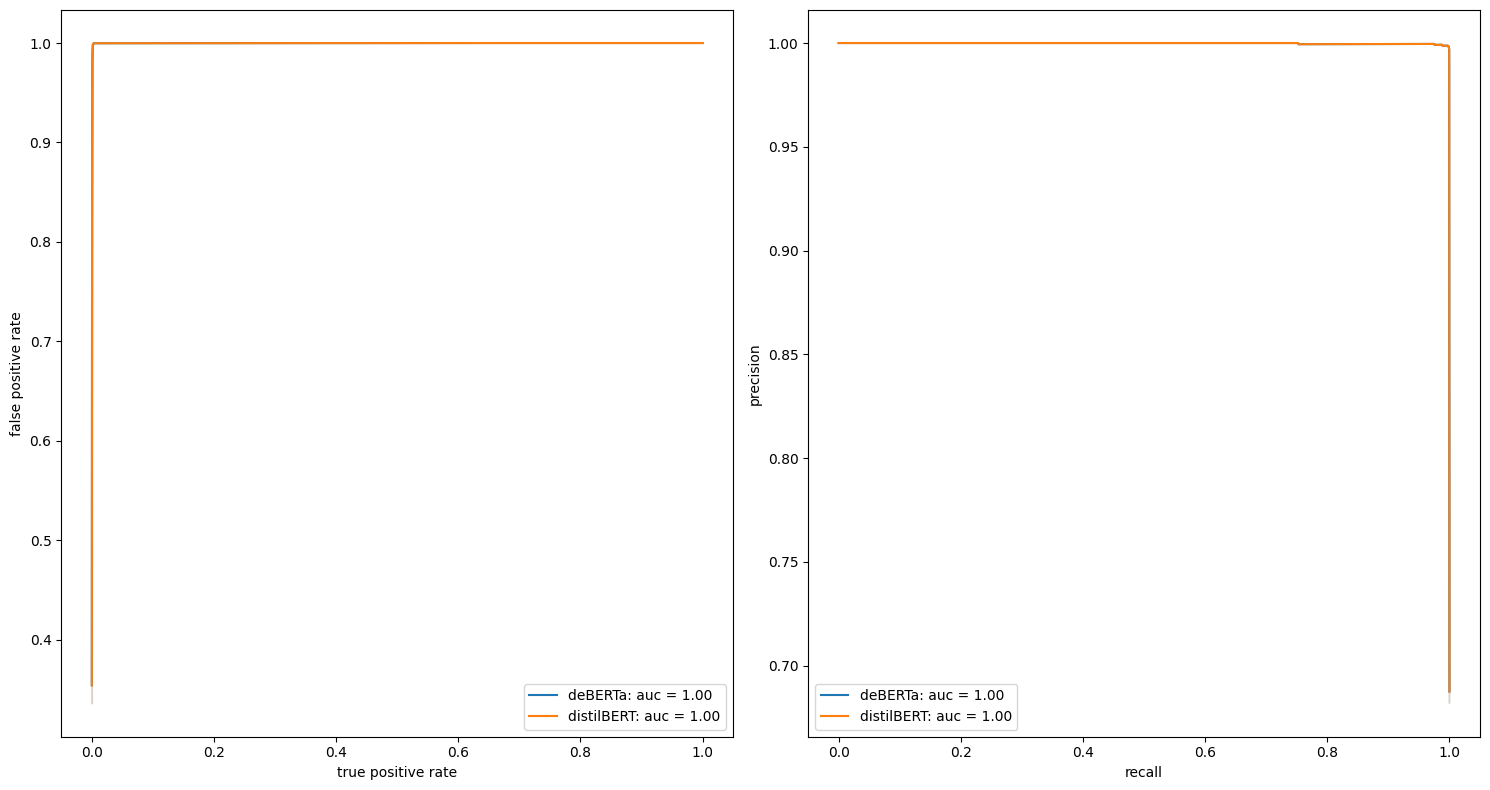

In [38]:
labels = ['deBERTa', 'distilBERT']

plot_roc_pr(y_test, [y_probas['deberta'], y_probas['distilbert']], labels, save="roc_pr.jpg", save_format="jpg")
